## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:02<00:00, 11071147.16it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175649.89it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3274448.74it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24648718.03it/s]


Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 1028),
            nn.BatchNorm1d(1028),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p=0.2),

            nn.Linear(1028, 1028),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Linear(1028, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1028]         806,980
       BatchNorm1d-3                 [-1, 1028]           2,056
         LeakyReLU-4                 [-1, 1028]               0
           Dropout-5                 [-1, 1028]               0
            Linear-6                 [-1, 1028]       1,057,812
         LeakyReLU-7                 [-1, 1028]               0
            Linear-8                   [-1, 10]          10,290
Total params: 1,877,138
Trainable params: 1,877,138
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 7.16
Estimated Total Size (MB): 7.22
----------------------------------------------------------------


Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 25

Обучаем по аналогии с прошлой лабы

In [10]:
predicted_labels = []
real_labels = []

for epoch in range(epochs):
    running_loss = 0.
    for batch in train_loader:
        batch[0] = batch[0].to(device)
        optimizer.zero_grad()

        y_predicted = model(batch[0])
        y_true = torch.eye(10)[batch[1]].to(device)

        loss = loss_fn(y_predicted, y_true)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

    print(f'Epoch: {epoch+1}, Train loss: {running_loss:.5f}')

Epoch: 1, Train loss: 239.03920
Epoch: 2, Train loss: 166.73052
Epoch: 3, Train loss: 149.83014
Epoch: 4, Train loss: 136.85643
Epoch: 5, Train loss: 128.81556
Epoch: 6, Train loss: 120.63065
Epoch: 7, Train loss: 114.72190
Epoch: 8, Train loss: 108.42996
Epoch: 9, Train loss: 102.48006
Epoch: 10, Train loss: 97.52461
Epoch: 11, Train loss: 94.35547
Epoch: 12, Train loss: 88.80936
Epoch: 13, Train loss: 85.18947
Epoch: 14, Train loss: 82.86755
Epoch: 15, Train loss: 78.75736
Epoch: 16, Train loss: 76.02591
Epoch: 17, Train loss: 71.68998
Epoch: 18, Train loss: 70.14146
Epoch: 19, Train loss: 67.13554
Epoch: 20, Train loss: 63.83136
Epoch: 21, Train loss: 62.29143
Epoch: 22, Train loss: 59.96019
Epoch: 23, Train loss: 57.50958
Epoch: 24, Train loss: 54.91170
Epoch: 25, Train loss: 53.85294


Оценим модель

In [11]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch[0] = batch[0].to(device)

        y_predicted = model(batch[0])
        y_true = torch.eye(10)[batch[1]].to(device)

        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

In [12]:
predicted_labels = torch.cat(predicted_labels).to('cpu')
real_labels = torch.cat(real_labels).to('cpu')

In [13]:
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [14]:
test_acc

tensor(0.8966)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [42]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards

            nn.Linear(input_shape, 2048),
            nn.ReLU(),

            nn.Linear(2048, 2048),
            nn.ReLU(),

            nn.Linear(2048, 2048),
            nn.ReLU(),

            nn.Linear(2048, 2048),
            nn.ReLU(),

            nn.Linear(2048, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [43]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 2048]       4,196,352
              ReLU-5                 [-1, 2048]               0
            Linear-6                 [-1, 2048]       4,196,352
              ReLU-7                 [-1, 2048]               0
            Linear-8                 [-1, 2048]       4,196,352
              ReLU-9                 [-1, 2048]               0
           Linear-10                   [-1, 10]          20,490
Total params: 14,217,226
Trainable params: 14,217,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 54.23
Esti

In [45]:
model = OverfittingNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [46]:
def test_loss_print():
    global model

    model.eval()
    running_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch[0] = batch[0].to(device)

            y_predicted = model(batch[0])
            y_true = torch.eye(10)[batch[1]].to(device)

            loss = loss_fn(y_predicted, y_true)
            running_loss += loss.item()
    return running_loss

In [47]:
predicted_labels = []
real_labels = []
train_loss = []
test_loss = []

for epoch in range(epochs):
    running_loss = 0.
    for batch in train_loader:
        model.train()
        batch[0] = batch[0].to(device)
        optimizer.zero_grad()

        y_predicted = model(batch[0])
        y_true = torch.eye(10)[batch[1]].to(device)

        loss = loss_fn(y_predicted, y_true)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

    test_loss_tmp = test_loss_print() / len(test_loader.dataset)
    train_loss_tmp = running_loss / len(train_loader.dataset)
    test_loss.append(test_loss_tmp)
    train_loss.append(train_loss_tmp)
    print(f'Epoch: {epoch+1}, Train loss: {train_loss_tmp:.5f}, Test loss: {test_loss_tmp:.5f}')

Epoch: 1, Train loss: 0.00439, Test loss: 0.00188
Epoch: 2, Train loss: 0.00321, Test loss: 0.00169
Epoch: 3, Train loss: 0.00293, Test loss: 0.00164
Epoch: 4, Train loss: 0.00273, Test loss: 0.00155
Epoch: 5, Train loss: 0.00264, Test loss: 0.00150
Epoch: 6, Train loss: 0.00252, Test loss: 0.00148
Epoch: 7, Train loss: 0.00247, Test loss: 0.00145
Epoch: 8, Train loss: 0.00239, Test loss: 0.00152
Epoch: 9, Train loss: 0.00236, Test loss: 0.00138
Epoch: 10, Train loss: 0.00233, Test loss: 0.00156


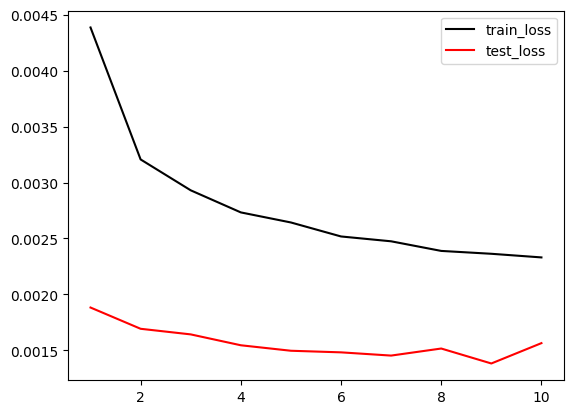

In [48]:
plt.plot(np.arange(1, epochs+1), train_loss, label='train_loss', color='black')
plt.plot(np.arange(1, epochs+1), test_loss, label='test_loss', color='red')
plt.legend()

Как видите потери на тренировочном сэмпле уменьшаются, но на тесте - не сильно уменьшаются.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [61]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards

            nn.Linear(input_shape, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2),

            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2),

            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.2),

            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(negative_slope=0.1),

            nn.Linear(2048, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [62]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 2048]       1,607,680
       BatchNorm1d-3                 [-1, 2048]           4,096
         LeakyReLU-4                 [-1, 2048]               0
           Dropout-5                 [-1, 2048]               0
            Linear-6                 [-1, 2048]       4,196,352
       BatchNorm1d-7                 [-1, 2048]           4,096
         LeakyReLU-8                 [-1, 2048]               0
           Dropout-9                 [-1, 2048]               0
           Linear-10                 [-1, 2048]       4,196,352
      BatchNorm1d-11                 [-1, 2048]           4,096
        LeakyReLU-12                 [-1, 2048]               0
          Dropout-13                 [-1, 2048]               0
           Linear-14                 [-

Устанавливаем все параметры как в предыдущем примере

In [63]:
model = FixedNeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [64]:
def test_loss_print():
    global model

    model.eval()
    running_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch[0] = batch[0].to(device)

            y_predicted = model(batch[0])
            y_true = torch.eye(10)[batch[1]].to(device)

            loss = loss_fn(y_predicted, y_true)
            running_loss += loss.item()
    return running_loss

In [65]:
predicted_labels = []
real_labels = []
train_loss = []
test_loss = []

for epoch in range(epochs):
    running_loss = 0.
    for batch in train_loader:
        model.train()
        batch[0] = batch[0].to(device)
        optimizer.zero_grad()

        y_predicted = model(batch[0])
        y_true = torch.eye(10)[batch[1]].to(device)

        loss = loss_fn(y_predicted, y_true)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

    test_loss_tmp = test_loss_print() / len(test_loader.dataset)
    train_loss_tmp = running_loss / len(train_loader.dataset)
    test_loss.append(test_loss_tmp)
    train_loss.append(train_loss_tmp)
    print(f'Epoch: {epoch+1}, Train loss: {train_loss_tmp:.5f}, Test loss: {test_loss_tmp:.5f}')

Epoch: 1, Train loss: 0.00398, Test loss: 0.00204
Epoch: 2, Train loss: 0.00361, Test loss: 0.00203
Epoch: 3, Train loss: 0.00354, Test loss: 0.00207
Epoch: 4, Train loss: 0.00345, Test loss: 0.00178
Epoch: 5, Train loss: 0.00334, Test loss: 0.00172
Epoch: 6, Train loss: 0.00319, Test loss: 0.00159
Epoch: 7, Train loss: 0.00311, Test loss: 0.00159
Epoch: 8, Train loss: 0.00300, Test loss: 0.00148
Epoch: 9, Train loss: 0.00294, Test loss: 0.00162
Epoch: 10, Train loss: 0.00289, Test loss: 0.00155


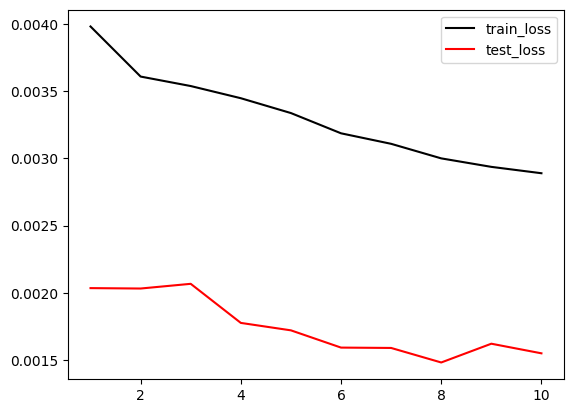

In [66]:
plt.plot(np.arange(1, epochs+1), train_loss, label='train_loss', color='black')
plt.plot(np.arange(1, epochs+1), test_loss, label='test_loss', color='red')
plt.legend()

### Conclusions:
Как вы можете видеть, замена ReLu на более дифференцируемый LeakyReLu и добавление некоторых регуляризаций, таких как Dropout и BatchNorm, может спасти день. Это кажется не таким очевидным, но использование другого набора данных может показать вам эффект. В целом BatchNorms был представлен в 2015 году и это был прорыв в глубоком обучении. Неудивительно, что в сочетании с другими регуляризациями это может улучшить производительность модели.